# AIFFEL 세 번째 프로젝트 : 고양이 수염 스티커 붙이기
1. 이미지 저장 폴더 만들기
```
$ mkdir -p ~/aiffel/camera_sticker/models
$ mkdir -p ~/aiffel/camera_sticker/images
```
2. 왕관 이미지 저장
```
$ wget https://aiffelstaticprd.blob.core.windows.net/media/original_images/king.png
$ wget https://aiffelstaticprd.blob.core.windows.net/media/original_images/hero.png
$ mv king.png hero.png ~/aiffel/camera_sticker/images
```
3. 이미지 처리 관련 패키지 설치
```
$ pip install opencv-python
$ pip install cmake
$ pip install dlib
```

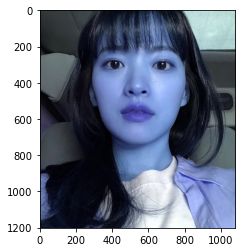

In [592]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/selfy.jpg'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서

img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
img_add = img_bgr.copy() # 불투명 스티커 붙일 이미지
plt.imshow(img_show)
plt.show()

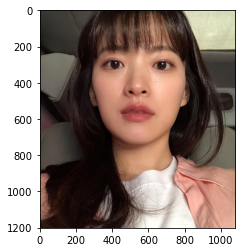

In [558]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 색 보정!
img_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

In [543]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
img_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB) # RGB로 변환
dlib_rects = detector_hog(img_rgb, 1) # 찾은 얼굴영역 좌표
# dlib.rectangles 타입의 객체를 반환, dlib.rectangle 객체의 배열 형태
# print(dlib_rects)

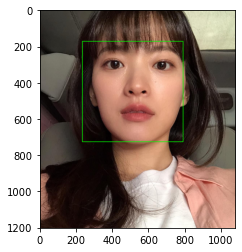

In [544]:
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [545]:
# 저장한 landmark 모델 불러오기
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)
list_landmarks = []

for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks))

1


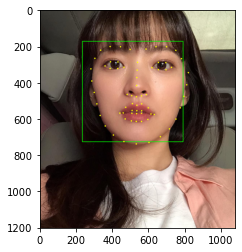

In [546]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 4, (0, 255, 255), -1) # 5: 원크기, -1: yellow
        
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

In [547]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30])
    x = landmark[0][0]
    y = landmark[29][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(532, 416)
(x,y) : (280,372)
(w,h) : (556,556)


In [561]:
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = img_sticker[180:330, :]
# plt.imshow(img_sticker)
print (img_sticker.shape)

(150, 512, 3)


In [613]:
# 사각형 위에 스티커 이미지를 추가하기 위해 x, y 좌표 조정
refined_x = x   # left
refined_y = y   # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (280,372)


In [550]:
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
print(sticker_area.shape)
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

(150, 512, 3)


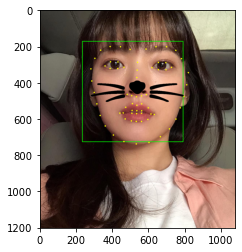

In [552]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

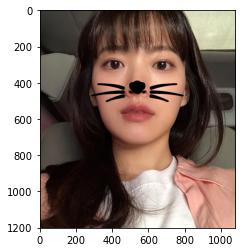

In [559]:
sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

# 번외) 스티커 불투명도 낮추기
- 노드에 잠깐 등장하는 코드로 스티커 불투명도 조절을 시도했다.

    
     
    
- `cv2.addWeighted(img1, alpha, img2, beta, gamma)`
    >$ f(x) = \alpha*img1 + \beta(=1 - \alpha)*img2 + \gamma $
    - 한 이미지로 합성할 두 이미지 img1과 img2의 비중을 조절하는 원리를 이용한 것으로
    - img1, img2 : 합성할 이미지
    - $\alpha$, $\beta$ : 이미지의 비중(합해서 1: 합해서 한 이미지가 되어야 하므로)
    - $ \gamma $ : 두 이미지에 가감할 상수  
    
    
    
    
- `cv2.seamlessClone(src, dst, mask, coords, flags, output)`
    - 두 이미지의 특징을 알아서 합성하는 기능
    - src, dst : 입력 이미지(배경, 합성이미지)
    - mask : src에서 합성하고자 하는 영역 255, 나머지 0
    - coords : src에 놓일 dst의 좌표(dst의 중앙좌표)
    - flags : 합성 방식
    - output(optional) : 합성 결과
    
코드의 설명과 이해는 **[여기](https://bkshin.tistory.com/entry/OpenCV-9-%EC%9D%B4%EB%AF%B8%EC%A7%80-%EC%97%B0%EC%82%B0)** 를 참고했다.

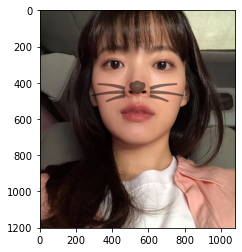

In [635]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/selfy.jpg'
img_bgr = cv2.imread(my_image_path)
img_add = img_bgr.copy()

sticker_area = img_bgr[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
add_sticker = cv2.addWeighted(img_sticker, 0.5, sticker_area, 0.5, 0)

img_add[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,add_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_add, cv2.COLOR_BGR2RGB))
plt.show()

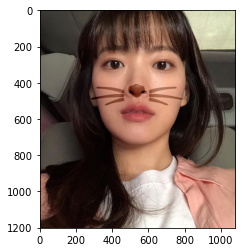

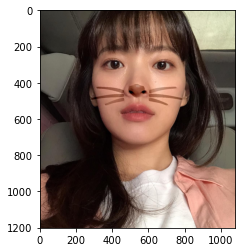

In [634]:
import numpy as np

my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/selfy.jpg'

img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_add2 = img_bgr.copy()
mask = np.full_like(img_sticker, 70)   # mask 지수로 불투명도 조절가능
center = (landmark[30][0],landmark[35][1]) # 스티커 중심과 코 좌표 같게

normal = cv2.seamlessClone(img_sticker, img_add2, mask, center, cv2.NORMAL_CLONE)
mixed = cv2.seamlessClone(img_sticker, img_add2, mask, center, cv2.MIXED_CLONE)

plt.imshow(cv2.cvtColor(normal, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(mixed, cv2.COLOR_BGR2RGB))
plt.show()

- `cv2.seamlessClone`에서 모드가 다르더라도 큰 차이는 없으나, normal에 비해 mixed 모드는 두 이미지의 특성을 모두 섞어주는 것으로 더 자연스러운 합성을 시도할 수 있다.

# +) 여러명 인식하기

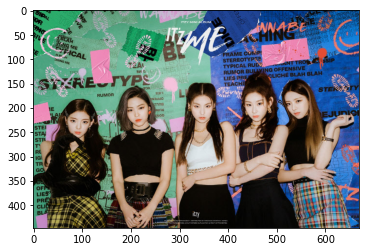

In [531]:
import os
from PIL import Image
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/itzy.jpg'
img_bgr = cv2.imread(my_image_path)
img_bgr1 = cv2.imread(my_image_path)

img_show = img_bgr.copy()
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

rectangles[[(319, 182) (371, 234)], [(510, 170) (561, 222)], [(187, 188) (239, 239)], [(66, 211) (118, 262)], [(429, 182) (481, 234)]]


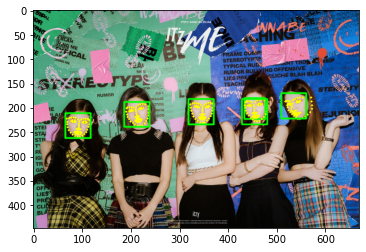

In [536]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # RGB로 변환
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)

print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

# 저장한 landmark 모델 불러오기
import os
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

list_landmarks, list_points = [], []

for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points += list(map(lambda p: (p.x, p.y), points.parts()))

n = 340//5
list_landmarks = [list_points[n*i:n*(i+1)] for i in range(0,5)]
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

### 1) 랜드마크 적용한 경우

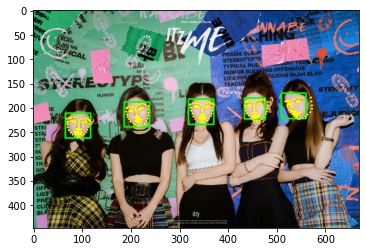

In [533]:
img_sticker, refined_xy, wh = [], [], [] # 루브릭 코드 설명 0

for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    w = dlib_rect.width()
    h = dlib_rect.width()
    x = landmark[30][0]
    y = landmark[8][1] # 루브릭 코드 설명 1
    d = (landmark[8][1] - min(landmark[24][1],landmark[19][1])) # 루브릭 코드 설명 2
    wh.append([w, h])
    # 사각형 위에 스티커 이미지를 추가하기 위해 x, y 좌표 조정
    refined_x = x - w//2                # left
    refined_y = y - 2*max(d,h)          # top  루브릭 코드 설명 3
    refined_xy.append([refined_x, refined_y])
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

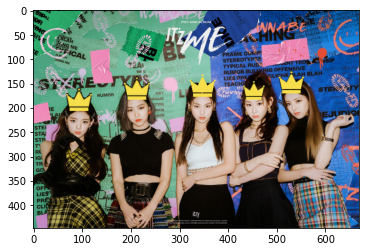

In [534]:
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/king.png'
img_sticker = cv2.imread(sticker_path)

for wh, refined_xy in list(zip(wh, refined_xy)):
    img_sticker = cv2.resize(img_sticker, (wh[0], wh[1]))
    sticker_area = img_bgr[refined_xy[1]:refined_xy[1]+img_sticker.shape[0], refined_xy[0]:refined_xy[0]+img_sticker.shape[1]]

    img_bgr[refined_xy[1]:refined_xy[1]+img_sticker.shape[0], refined_xy[0]:refined_xy[0]+img_sticker.shape[1]] = \
        np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))

### 2) 랜드마크 적용하지 않은 경우 ; 인식칸 적용한 경우

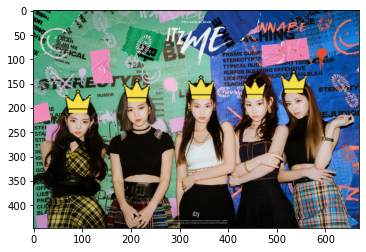

In [535]:
img_sticker1, refined_xy1, wh1 = [], [], []

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    h = dlib_rect.width()
    w = dlib_rect.width()
    
    wh1.append([w, h])
    # 사각형 위에 스티커 이미지를 추가하기 위해 x, y 좌표 조정
    refined_x = l                   # left
    refined_y = t - h               # top
    refined_xy1.append([refined_x, refined_y])
    
import os
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/king.png'
img_sticker1 = cv2.imread(sticker_path)

for wh, refined_xy in list(zip(wh1, refined_xy1)):
    img_sticker1 = cv2.resize(img_sticker, (wh[0], wh[1]))
    sticker_area1 = img_bgr1[refined_xy[1]:refined_xy[1]+img_sticker1.shape[0], refined_xy[0]:refined_xy[0]+img_sticker1.shape[1]]

    img_bgr1[refined_xy[1]:refined_xy[1]+img_sticker1.shape[0], refined_xy[0]:refined_xy[0]+img_sticker1.shape[1]] = \
        np.where(img_sticker1==0,sticker_area1,img_sticker1).astype(np.uint8)

    plt.imshow(cv2.cvtColor(img_bgr1, cv2.COLOR_BGR2RGB))

---
# 루브릭
### 1. 자기만의 카메라앱 기능 구현을 완수하였다.

### 2. 스티커 이미지를 정확한 원본 위치에 반영하였다.
- 1, 2 위의 결과로 완수한 것을 볼 수 있다.

### 3. 카메라 스티커앱을 다양한 원본 이미지에 적용했을 때의 문제점을 체계적으로 분석하였다.
- 한 사람의 셀카나 여러명 사진 두 경우 모두, 얼굴 각도, 얼굴 인식 크기 등에 따라 스티커 적용이 정면 사진보다 약간 부자연스러운 결과가 아쉬웠다. 인식 크기의 경우에는 인식칸을 기준으로 스티커 영역을 정하면 조금의 개선이 있었지만, 얼굴 각도의 경우에는 회전도 필요하기 때문에 더 깊은 이해가 필요할 것이다.
- 여러명의 왕관 스티커
    - 왕관 스티커처럼 **이목구비에 씌우는 스티커가 아닌 경우, 랜드마크가 아닌 얼굴 인식 네모를 참조하는 것이 스티커 위치를 더 잘 잡을 수 있을 것이다.** 채령(오른쪽에서 두번째 사람)의 경우 인식한 얼굴이 작고(스티커 영역이 (44,44,3)/다른 사람(53,53,3)), 다른 사람에 비해 코끝 랜드마크가 사각형 중심에서 더 아래쪽에 표시되어있어 노드와 같은 식으로 스티커 영역을 정했을 때, 스티커가 눈을 가리게 되었다.
    - 그리고 랜드마크 사용하지 않는 버전과 랜드마크를 사용한 버전 두 개로 진행했을 때, 결과는 비슷하게 나왔다. 두 결과 모두 얼굴 인식이 작은 크기(오른쪽에서 두번째)일 때, `dlib_rect.width()`가 작아 위치를 지정할 때 랜드마크 좌표와 인식칸 크기의 차이를 이용한다 하더라도(`refined_x, refined_y`을 조절한다 하더라도) 큰 차이가 없었다.
    - 코드 설명
        - `img_sticker, refined_xy, wh = [], [], []` : 여러 명의 정보를 리스트로 보관하기 위한 리스트 초기화
        - `y = landmark[8][1]` : 스티커 크기의 2배만큼 빼주기 위해 턱끝의 랜드마크를 이용했다.
        - `d = (landmark[8][1] - min(landmark[24][1],landmark[19][1]))` : 턱끝과 눈썹 둘 중 높은 부분의 값을 빼주어 얼굴 인식칸의 크기와 랜드마크의 차이를 보완하고자 했다.
        - `refined_y = y - 2*max(d,h)` : 이목구비에서 더 많이 떨어지게 하기 위해, 랜드마크의 차이, 인식칸의 크기 중 더 큰 것을 스티커 top부분으로 대입했다.

---
# 마무리
20210125 MON
- 원래 했던 프로젝트가 부주의로 날아가 다시 시행했고, 더 이해도 높은 프로젝트를 시행했다.
- 역시 한 명의 사진보다 여러 명의 사진 인식이 훨씬 어려웠고, 예전 카메라 어플에서도 왜 처음엔 한 명 인식만 시도했었는지 알 것 같았다. 데이터 읽는 방식은 비슷했지만, 스티커 모양에 따라 사람 인식 크기마다 적용해야하는 범위 차이가 생각보다 커서, 코드의 이해 문제보다 의외로 감각적으로 풀어야하는 문제였다.
- openCV는 C에서만 사용하는 예시를 많이 봤었는데, 파이썬으로 하니 C보다 이해도가 더 높아 좋았고, cv2의 다양한 패키지가 많아 영상처리에서 많이 사랑받는 이유를 알게 됐다. 이미지 및 영상처리를 더 깊게 파고 싶다면 openCV의 기초를 파악할 것!
- 불투명한 스티커 붙이기도 해봤는데, 밋밋한 스티커에 색 입혀서 붙이는 것도 재밌을 것 같다.